## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
print("numpy", np.__version__)
print("pandas", pd.__version__)
print("sklearn", sklearn.__version__)

numpy 2.3.2
pandas 2.3.3
sklearn 1.8.0


# Data Preprocessing

## Load JSONL Dataset

In [3]:
# Path given by your environment
DATA_PATH = "problems_data.jsonl"

df = pd.read_json(DATA_PATH, lines=True)
df.head()


,title,description,input_description,output_description,sample_io,problem_class,problem_score,url
0,Uuu,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,"[{'input': '7 10', 'output': '1 2 2 3 1 3 3 4 ...",hard,9.7,https://open.kattis.com/problems/uuu
1,House Building,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,"[{'input': '0 2 3 2 50 60 50 30 50 40', 'outpu...",hard,9.7,https://open.kattis.com/problems/husbygge
2,Mario or Luigi,Mario and Luigi are playing a game where they ...,,,"[{'input': '', 'output': ''}]",hard,9.6,https://open.kattis.com/problems/marioorluigi
3,The Wire Ghost,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,"[{'input': '4 3 3 C 2 C 1 C', 'output': 'GHOST...",hard,9.6,https://open.kattis.com/problems/thewireghost
4,Barking Up The Wrong Tree,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,"[{'input': '2 0 10 0 10 10', 'output': '14.14'...",hard,9.6,https://open.kattis.com/problems/barktree


## Dataset Overview

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4112 entries, 0 to 4111
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               4112 non-null   object 
 1   description         4112 non-null   object 
 2   input_description   4112 non-null   object 
 3   output_description  4112 non-null   object 
 4   sample_io           4112 non-null   object 
 5   problem_class       4112 non-null   object 
 6   problem_score       4112 non-null   float64
 7   url                 4112 non-null   object 
dtypes: float64(1), object(7)
memory usage: 257.1+ KB


In [5]:
df['problem_class'].value_counts()


problem_class
hard      1941
medium    1405
easy       766
Name: count, dtype: int64

## Handle Missing Values & Combine Text Fields

In [6]:
# Fill missing text fields
text_columns = ['title', 'description', 'input_description', 'output_description']

for col in text_columns:
    if col in df.columns:
        df[col] = df[col].fillna("")

# Combine all text into one column
df['combined_text'] = (
    df['title'] + " " +
    df['description'] + " " +
    df['input_description'] + " " +
    df['output_description']
)

df[['combined_text']].head()


,combined_text
0,Uuu Unununium (Uuu) was the name of the chemic...
1,House Building A number of eccentrics from cen...
2,Mario or Luigi Mario and Luigi are playing a g...
3,The Wire Ghost Žofka is bending a copper wire....
4,Barking Up The Wrong Tree Your dog Spot is let...


# Feature Engineering

## Feature Engineering (Optional Extra Features)

In [7]:
# Text length
df['text_length'] = df['combined_text'].apply(len)

# Count digits
df['digit_count'] = df['combined_text'].str.count(r'\d')

# Count math symbols
df['symbol_count'] = df['combined_text'].str.count(r'[\+\-\*/=<>]')

# Algorithm keywords
keywords = ['graph', 'tree', 'dp', 'dynamic programming', 'recursion',
            'greedy', 'stack', 'queue', 'binary search']

for kw in keywords:
    df[f'kw_{kw}'] = df['combined_text'].str.lower().str.contains(kw).astype(int)

df.head()


,title,description,input_description,output_description,sample_io,problem_class,problem_score,url,combined_text,text_length,...,symbol_count,kw_graph,kw_tree,kw_dp,kw_dynamic programming,kw_recursion,kw_greedy,kw_stack,kw_queue,kw_binary search
0,Uuu,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,"[{'input': '7 10', 'output': '1 2 2 3 1 3 3 4 ...",hard,9.7,https://open.kattis.com/problems/uuu,Uuu Unununium (Uuu) was the name of the chemic...,1672,...,3,1,0,0,0,0,0,0,0,0
1,House Building,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,"[{'input': '0 2 3 2 50 60 50 30 50 40', 'outpu...",hard,9.7,https://open.kattis.com/problems/husbygge,House Building A number of eccentrics from cen...,1422,...,3,0,0,0,0,0,0,0,0,0
2,Mario or Luigi,Mario and Luigi are playing a game where they ...,,,"[{'input': '', 'output': ''}]",hard,9.6,https://open.kattis.com/problems/marioorluigi,Mario or Luigi Mario and Luigi are playing a g...,1334,...,1,0,0,0,0,0,0,0,0,0
3,The Wire Ghost,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,"[{'input': '4 3 3 C 2 C 1 C', 'output': 'GHOST...",hard,9.6,https://open.kattis.com/problems/thewireghost,The Wire Ghost Žofka is bending a copper wire....,1390,...,0,0,0,0,0,0,0,0,0,0
4,Barking Up The Wrong Tree,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,"[{'input': '2 0 10 0 10 10', 'output': '14.14'...",hard,9.6,https://open.kattis.com/problems/barktree,Barking Up The Wrong Tree Your dog Spot is let...,2261,...,0,0,1,0,0,0,0,0,0,0


In [8]:
# Text feature
TEXT_FEATURE = 'combined_text'

# Numeric engineered features 
NUMERIC_FEATURES = [
    'text_length',
    'digit_count',
    'symbol_count',
    'kw_graph',
    'kw_tree',
    'kw_dp',
    'kw_recursion'
]


## Prepare Features & Targets

In [9]:
# Input features
X = df[[TEXT_FEATURE] + NUMERIC_FEATURES]

# Target for classification
y_class = df['problem_class']

# Target for regression
y_score = df['problem_score']

X.head()


,combined_text,text_length,digit_count,symbol_count,kw_graph,kw_tree,kw_dp,kw_recursion
0,Uuu Unununium (Uuu) was the name of the chemic...,1672,15,3,1,0,0,0
1,House Building A number of eccentrics from cen...,1422,12,3,0,0,0,0
2,Mario or Luigi Mario and Luigi are playing a g...,1334,16,1,0,0,0,0
3,The Wire Ghost Žofka is bending a copper wire....,1390,16,0,0,0,0,0
4,Barking Up The Wrong Tree Your dog Spot is let...,2261,8,0,0,1,0,0


## Train-Test Split

In [10]:
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X,
    y_class,
    test_size=0.2,
    random_state=42,
    stratify=y_class
)


# MODEL 1: Classification (Easy / Medium / Hard)

## Classification Pipeline (TF-IDF + Logistic Regression)

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        # Text → TF-IDF
        ('text', TfidfVectorizer(
            stop_words='english',
            max_features=5000,
            ngram_range=(1, 2)
        ), TEXT_FEATURE),

        # Numeric features → Scaling
        ('num', StandardScaler(), NUMERIC_FEATURES)
    ]
)


In [12]:
clf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1,2),
        stop_words='english'
    )),
    ('clf', LogisticRegression(
        max_iter=1000,
        n_jobs=-1
    ))
])

clf_pipeline


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


## Train Classification Model

In [13]:
clf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', LinearSVC())
])

clf_pipeline.fit(X_train, y_class_train)

C:\Users\Praveen Roj\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('text', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

## Classification Evaluation

In [14]:
y_class_pred = clf_pipeline.predict(X_test)

accuracy = accuracy_score(y_class_test, y_class_pred)
cm = confusion_matrix(y_class_test, y_class_pred)

print(f"Classification Accuracy: {accuracy:.4f}")


Classification Accuracy: 0.4812


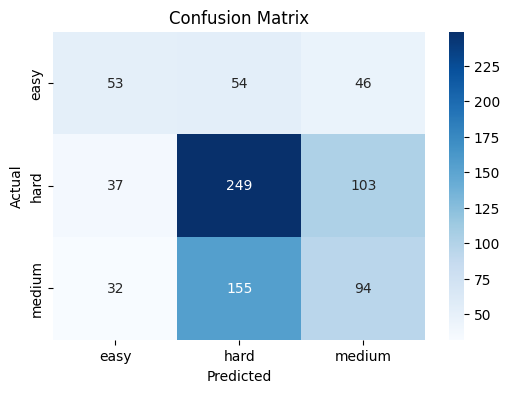

In [15]:
plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=clf_pipeline.classes_,
    yticklabels=clf_pipeline.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



# MODEL 2: Regression (Difficulty Score)

## Regression Pipeline (TF-IDF + Random Forest)

In [16]:
reg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1,2),
        stop_words='english'
    )),
    ('reg', RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

reg_pipeline


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('reg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


## Train Regression Model

In [17]:
X_train_r, X_test_r, y_score_train, y_score_test = train_test_split(
    X,
    y_score,
    test_size=0.2,
    random_state=42
)

In [18]:
reg_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

reg_pipeline.fit(X_train_r, y_score_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('text', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers

## Regression Evaluation

In [19]:
y_score_pred = reg_pipeline.predict(X_test_r)

mae = mean_absolute_error(y_score_test, y_score_pred)
rmse = np.sqrt(mean_squared_error(y_score_test, y_score_pred))

print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE : 1.6855
RMSE: 2.0349


## Prediction Function (For Web / Manual Use)

In [20]:
def predict_difficulty(description, input_desc, output_desc,
                       clf_pipeline, reg_pipeline):
    """
    Predict difficulty class and score for a programming problem
    using trained pipelines with text + engineered features.
    """

    # 1. Combine text
    combined_text = description + " " + input_desc + " " + output_desc

    # 2. Create engineered features (MUST match training)
    data = {
        "combined_text": combined_text,
        "text_length": len(combined_text),
        "digit_count": sum(c.isdigit() for c in combined_text),
        "symbol_count": len([c for c in combined_text if c in "+-*/=<>" ]),
        "kw_graph": int("graph" in combined_text.lower()),
        "kw_tree": int("tree" in combined_text.lower()),
        "kw_dp": int("dp" in combined_text.lower() or "dynamic programming" in combined_text.lower()),
        "kw_recursion": int("recursion" in combined_text.lower())
    }

    # 3. Convert to DataFrame (single row)
    
    X_input = pd.DataFrame([data])

    # 4. Predictions
    pred_class = clf_pipeline.predict(X_input)[0]
    pred_score = reg_pipeline.predict(X_input)[0]

    return pred_class, round(pred_score, 2)



## Test With Sample Input

In [21]:
sample_desc = """
Given a graph with N nodes and M edges, find the shortest path
from node 1 to node N using BFS.
"""

sample_input = "First line contains N and M. Next M lines contain edges."
sample_output = "Print the minimum distance."

predict_difficulty(
    sample_desc,
    sample_input,
    sample_output,
    clf_pipeline,
    reg_pipeline
)


('medium', np.float64(4.44))

## Save Models (For Web App)

In [22]:
import joblib

# Save classification model
joblib.dump(clf_pipeline, "difficulty_classifier.pkl")

# Save regression model
joblib.dump(reg_pipeline, "difficulty_regressor.pkl")

print(" Models saved successfully for web app use")

 Models saved successfully for web app use
